In [1]:
# DELETE BEFORE PUBLISHING
# This is just here so you can preview the styling on your local machine

from IPython.core.display import HTML
HTML("""
<style>
.usecase-title, .usecase-duration, .usecase-section-header {
    padding-left: 15px;
    padding-bottom: 10px;
    padding-top: 10px;
    padding-right: 15px;
    background-color: #0f9295;
    color: #fff;
}

.usecase-title {
    font-size: 1.7em;
    font-weight: bold;
}

.usecase-authors, .usecase-level, .usecase-skill {
    padding-left: 15px;
    padding-bottom: 7px;
    padding-top: 7px;
    background-color: #baeaeb;
    font-size: 1.4em;
    color: #121212;
}

.usecase-level-skill  {
    display: flex;
}

.usecase-level, .usecase-skill {
    width: 50%;
}

.usecase-duration, .usecase-skill {
    text-align: right;
    padding-right: 15px;
    padding-bottom: 8px;
    font-size: 1.4em;
}

.usecase-section-header {
    font-weight: bold;
    font-size: 1.5em;
}

.usecase-subsection-header, .usecase-subsection-blurb {
    font-weight: bold;
    font-size: 1.2em;
    color: #121212;
}

.usecase-subsection-blurb {
    font-size: 1em;
    font-style: italic;
}
</style>
""")

<div class="usecase-title">Pedestrian Foot Traffic Business Case</div>

<div class="usecase-authors"><b>Authored by: </b> Ngoc Dung Hyunh</div>

<div class="usecase-duration"><b>Duration:</b> 40 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Advanced</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python</div>
</div>

<div class="usecase-section-header">Scenario</div>

### As a business owner, I want to know how much pedestrian foot traffic occurs in a potential new business location

### I would like to be able to compare pedestrian traffic through the day, week and month. 

### I would like to see visualisations that can help in deciding where I can start my new venture

<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
   - understand how to access and collect data from Melbourne Open Data
   - have explored datasets such as Pedestrian Counting System and sensor location
   - learnt how to visualise data using different mapping visualisation techniques

<div class="usecase-section-header">A brief introduction to the datasets used</div>

The City of Melbourne provides comprehensive pedestrian traffic data, as well as sensor location data. In this use case we will utilise the __[Pedestrian Counting System - Past Hour (counts per minute)](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Past-Hour-counts-per-mi/d6mv-s43h)__ dataset

This dataset contains minute-by-minute directional pedestrian counts from the last over from pedestrian sensor devices located across the city. The data is updated every 15 minutes and can be used to determinate variations in pedestrian activity throughout the day.

We also utilise the City of Melbourne's __[Sensor Locations](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Sensor-Locations/h57g-5234)__ dataset. This data will be used to extract the location of these sensors which helps with visualisation.


<div class="usecase-section-header">Accessing and Loading data</div>

We aim to make a decision that will be informed by insights based on the latest data. 

In order to get this data, we can create a function to extract, transform and load (ETL) pedestrian traffic data every 15 minutes. 

First, we will do ETL  for Sensor Locations and Pedestrian Counting System - Past Hour (counts per minute). 

We will then merge these datasets. 

In [21]:
import requests
import pandas as pd
from api_key import API_KEY
import time

BASE_URL = 'https://data.melbourne.vic.gov.au/api/records/1.0/search/?dataset='

# function to get sensor location data
def sensor_location(base_url):
    sensor_dataset = 'pedestrian-counting-system-sensor-locations'
    n_records = '&q=&rows=108'
    sensor_url = f'{base_url}{sensor_dataset}{n_records}'
    result = requests.get(sensor_url)
    result_json = result.json()
    records = result_json['records']
    sensor_df = pd.json_normalize(records)
    sensor_location = sensor_df[['fields.location_id', 'fields.sensor_description', 'fields.latitude', 'fields.longitude']]
    sensor_location.columns = ["Sensor ID", "Sensor Description", "lat", "lon"]
    return sensor_location

# function to get the City of Melbourne's Pedestrian Counting System - Past Hour (counts per minute) 
def fifty_minute_count(base_url, location):
    dataset = 'pedestrian-counting-system-monthly-counts-per-hour'
    n_records = '&q=&rows=10000'
    count_url = f'{base_url}{dataset}{n_records}'
    result = requests.get(count_url)
    result_json = result.json()
    records = result_json['records']
    df = pd.json_normalize(records)
    df = df[["fields.timestamp", "fields.locationid","fields.total_of_directions"]]
    df.columns = ["DateTime", "Sensor ID", "Count"]
    weekdays = {
        0: "Monday",
        1: "Tuesday",
        2: "Wednesday",
        3: "Thursday",
        4: "Friday",
        5: "Saturday",
        6: "Sunday"
    }
    times = df["DateTime"]
    last_time = times.sort_values(ascending=False).iloc[1].split("T")
    weekday = time.strptime(last_time[0],"%Y-%m-%d").tm_wday
    print(f"The latest data was updated on {weekdays[weekday]} {last_time[0]} at {last_time[1].split('.')[0] } at https://data.melbourne.vic.gov.au")
    
    #Transform data
    df["Count"] = pd.to_numeric(df["Count"])
    counting = pd.DataFrame(df[["Sensor ID", "Count"]].groupby(["Sensor ID"]).sum())
    counting.reset_index(level=0, inplace=True)
    counting["Sensor ID"] = counting["Sensor ID"].apply(lambda x: float(x))
    
    #Merge 2 dataset
    counting = pd.merge(counting, location, on='Sensor ID', how='inner')
    counting["Count"] = counting["Count"].apply(lambda x: float(x))
    
    return counting


In [22]:
#Get the data
location_data = sensor_location(BASE_URL)

counting_data = fifty_minute_count(BASE_URL, location_data)

The latest data was updated on Wednesday 2023-04-26 at 13:00:00+00:00 at https://data.melbourne.vic.gov.au


In [23]:
#View the output
print(counting_data.shape)

counting_data.head()

(75, 5)


,Sensor ID,Count,Sensor Description,lat,lon
0,1.0,152249.0,Bourke Street Mall (North),-37.813494,144.965153
1,10.0,12894.0,Victoria Point,-37.818765,144.947105
2,107.0,16484.0,Flagstaff station (East),-37.812463,144.956902
3,109.0,15583.0,La Trobe St- William St (South),-37.811937,144.956211
4,11.0,16865.0,Waterfront City,-37.815650,144.939707


<h3 style="text-align: center;">Overview of Data</h3>

| Columns | Description | Type |
| --- | --- | --- |
| Sensor ID | Unique reading ID | Categorical |
| Count | Hourly sum of Pedestrians | Numerical |
| Sensor Description | A description of where the sensor is located | Categorical |
| Lat | Latitude of each sensor | Numerical |
| Lon | Longitude of each sensor | Numerical |

<div class="usecase-section-header">Using Selenium to Crawl Data</div>

To help drive insight to informing our business scenario, we can compare the data from two different sensor locations. 

This means we can compare pedestrian foot traffic in two separate locations over different periods of the current date, as well as over a 4-week period. 

However, in order to get this data, we need to crawl the data from http://www.pedestrian.melbourne.vic.gov.au.

***Note*** Because we cannot use ***Sodapy*** to crawl the data from this website, We use another package __[***Selenium***](https://pypi.org/project/selenium/)__ to extract the data.

<img src="use-casespedestrian-traffic-analysis/resources/pedestrian_hourly.png">


In [7]:
# !Pip install selenium

In [34]:
#Set up Selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from time import sleep
from datetime import date
import numpy as np
import csv
from csv import reader
import matplotlib.pyplot as plt
import os.path

# Linux only
import platform
if platform.system() =="linux":
    if not os.path.isfile("chromedriver"):
        !wget "https://chromedriver.storage.googleapis.com/94.0.4606.41/chromedriver_linux64.zip"
        !unzip chromedriver_linux64.zip

chromeOptions = webdriver.ChromeOptions()
prefs = {"download.default_directory" : r"{}".format(os.getcwd())}
chromeOptions.add_experimental_option("prefs",prefs)

def daily_monthly_data():
    #Crawl data
    today = date.today()
    today = today.strftime("%d-%m-%Y")
    file_name = f"COM_24PM_{today}.csv"
    if os.path.exists(file_name):
        os.remove(file_name)
    driver = webdriver.Chrome(executable_path='./chromedriver', options=chromeOptions)
    driver.get("http://www.pedestrian.melbourne.vic.gov.au/")
    driver.find_element("xpath", f'//*[@id="dropdown-size-small"]').click()
    sleep(2)
    driver.find_element("xpath", f'/html/body/div/div/div[5]/div[2]/div/ul/li/a').click()
    sleep(5)
    
    #Cleaning data
    with open(file_name, 'r') as read_obj:
        csv_reader = reader(read_obj)
        daily_data = {}
        monthly_data = {}
        yearly_data = {}
        i = 0
        for row in csv_reader:
            if i in range(9, 87):
                daily_data[row[0]] =  row[1:]
            elif i in range(92,170):
                monthly_data[row[0]] =  row[1:]
            i+=1
        for sensor in daily_data:
            if len(daily_data[sensor]) == 0:
                daily_data[sensor] = [np.nan]*24
        for sensor in monthly_data:
            if len(monthly_data[sensor]) == 0:
                monthly_data[sensor] = [np.nan]*24

    #Return daily data and monthly data of sensors
    daily_data = pd.DataFrame(daily_data)
    monthly_data = pd.DataFrame(monthly_data)
    daily_data = daily_data.replace("N/A", np.nan)
    monthly_data = monthly_data.replace("N/A", np.nan)
    
    #Drop the first row
    daily_data = daily_data[1:].reset_index(drop=True)
    for column in daily_data.columns:
        daily_data[column] = pd.to_numeric(daily_data[column])
        daily_data = daily_data.replace(0, np.nan)
    
    #Drop the first row, & the Sensor Column
    monthly_data = monthly_data[1:].reset_index(drop=True)
    monthly_data.drop(columns=['Sensor'], inplace=True)
    
    for column in monthly_data.columns:
        monthly_data[column] = pd.to_numeric(monthly_data[column])
    
    os.remove(file_name)
    return daily_data, monthly_data

daily_data, monthly_data = daily_monthly_data()

#Rename columns of daily and monthly data because some sensors have different names on different datasets. 
columns = {"Collins St (North)": "Collins Street (North)",
          "Lincoln-Swanston (W)":"Lincoln-Swanston (West)",
          "RMIT Bld 80 - 445 Swanston Street": "Building 80 RMIT",
          "Flinders Ln - Degraves St (South)": "Flinders Ln -Degraves St (South)",
          "Flinders Ln - Degraves St (North)": "Flinders Ln -Degraves St (North)",
          "Flinders Ln - Degraves St (Crossing)": "Flinders Ln -Degraves St (Crossing)",
          "Flinders St - ACMI": "Flinders St- ACMI",
          "Spring St - Flinders St (West)": "Spring St- Flinders st (West)",
          "Macaulay Rd - Bellair St": "Macaulay Rd- Bellair St",
          "Harbour Esplanade - Pedestrian Path": "Harbour Esplanade (West) - Pedestrian path",
          "Harbour Esplanade - Bike Path": "Harbour Esplanade (West) - Bike Path",
           "Flinders La-Swanston St (West) Temporary": "Flinders La - Swanston St (West) Temporary",
           "380 Elizabeth St": "Flinders St-Swanston St (West)"
          }
daily_data.rename(columns=columns, inplace=True)
monthly_data.rename(columns=columns, inplace=True)

C:\Users\playroommountains\AppData\Local\Temp\ipykernel_11832\1340625470.py:30: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path='./chromedriver', options=chromeOptions)


In [35]:
#Show 5 columns of daily_data (updated every an hour)
daily_data.head()

,Bourke Street Mall (North),Bourke Street Mall (South),Melbourne Central,Town Hall (West),Princes Bridge,Flinders Street Station Underpass,Birrarung Marr,Webb Bridge,Southern Cross Station,Victoria Point,...,Harbour Esplanade (West) - Pedestrian Path,Harbour Esplanade (West) - Bike Path,Flinders St (South),Elizabeth St - Flinders St (East) - New footpath,Macaulay Rd (North),Queensberry St - Errol St (South),Errol St (West),Flagstaff station (East),William St - Little Lonsdale St (West),La Trobe St - William St (South)
0,46.0,52.0,297.0,118.0,120.0,167.0,NaN,3.0,11.0,2.0,...,25.0,1.0,89.0,184.0,2.0,7.0,6.0,22.0,27.0,27.0
1,23.0,13.0,134.0,63.0,75.0,54.0,NaN,2.0,4.0,1.0,...,6.0,1.0,18.0,139.0,1.0,NaN,6.0,21.0,23.0,18.0
2,9.0,16.0,83.0,34.0,32.0,29.0,NaN,NaN,2.0,2.0,...,2.0,1.0,15.0,56.0,NaN,NaN,3.0,5.0,32.0,12.0
3,12.0,10.0,86.0,12.0,34.0,25.0,NaN,NaN,5.0,1.0,...,2.0,1.0,16.0,42.0,NaN,NaN,3.0,6.0,12.0,6.0
4,6.0,20.0,72.0,33.0,44.0,44.0,NaN,2.0,6.0,1.0,...,6.0,1.0,19.0,37.0,1.0,NaN,7.0,2.0,13.0,6.0


In [29]:
#Show 5 columns of daily_data (updated every an hour)
monthly_data.head()

,Bourke Street Mall (North),Bourke Street Mall (South),Melbourne Central,Town Hall (West),Princes Bridge,Flinders Street Station Underpass,Birrarung Marr,Webb Bridge,Southern Cross Station,Victoria Point,...,Macaulay Rd-Bellair St,Harbour Esplanade (West) - Pedestrian Path,Harbour Esplanade (West) - Bike Path,Flinders St (South),Elizabeth St - Flinders St (East) - New footpath,Macaulay Rd (North),Queensberry St - Errol St (South),Errol St (West),Flagstaff station (East),William St - Little Lonsdale St (West)
0,60,56,338,247,122,134,NaN,6,13,3,...,1,14,6,72,193,1,5,6,24,41
1,34,37,152,102,49,50,NaN,3,5,3,...,1,6,3,40,93,3,3,4,13,15
2,19,19,105,38,45,20,NaN,1,6,1,...,2,3,2,24,50,1,3,2,5,15
3,13,15,71,34,36,25,NaN,1,4,1,...,0,3,1,21,46,1,6,5,3,9
4,7,10,54,25,43,42,NaN,3,6,2,...,0,2,1,20,41,1,0,9,7,7


<div class="usecase-section-header">Basic Map Visualisation</div>

Visualising data provides an easy way for us to detect patterns within the data. Using the python library __[folium](http://python-visualization.github.io/folium/)__, we can create a live pedestrian traffic map of the City of Melbourne.

This map will represent all of the data of the pedestrian sensor locations within the City of Melbourne.

This map is updated every 15 minutes for up-to-date pedestrian traffic information. 

In [ ]:
import folium
from folium.plugins import MarkerCluster
def map_visualization(data):
    locations = []
    for i in range(len(data)):
        row =data.iloc[i]
        location = [(row.lat,row.lon)]*int(row.Count)
        locations += location
      
    marker_cluster  = MarkerCluster(
      locations=locations,
      overlay=True,
      control=True,
      )
    m = folium.Map(location=[-37.8167, 144.967], zoom_start=15)
    marker_cluster.add_to(m)

    folium.LayerControl().add_to(m)
    
    m
    return m
map_visualization(counting_data)

As we can see, the majority of the pedestrian traffic takes place around Swanston street in the heart of the city

<div class="usecase-section-header">Basic Trend Visualisation</div>

Having developed a basic visualisation of our data, we can now produce a visualisation that shows us potential trends in pedestrian foot traffic. 

We can create a line chart that consists of two lines of different sensor locations at different times of day. 

Based on this visualisation, we can compare the rush hour and off-peak periods of the two sensors. 

This information has the potential to help inform our business owner of his new potential location. 

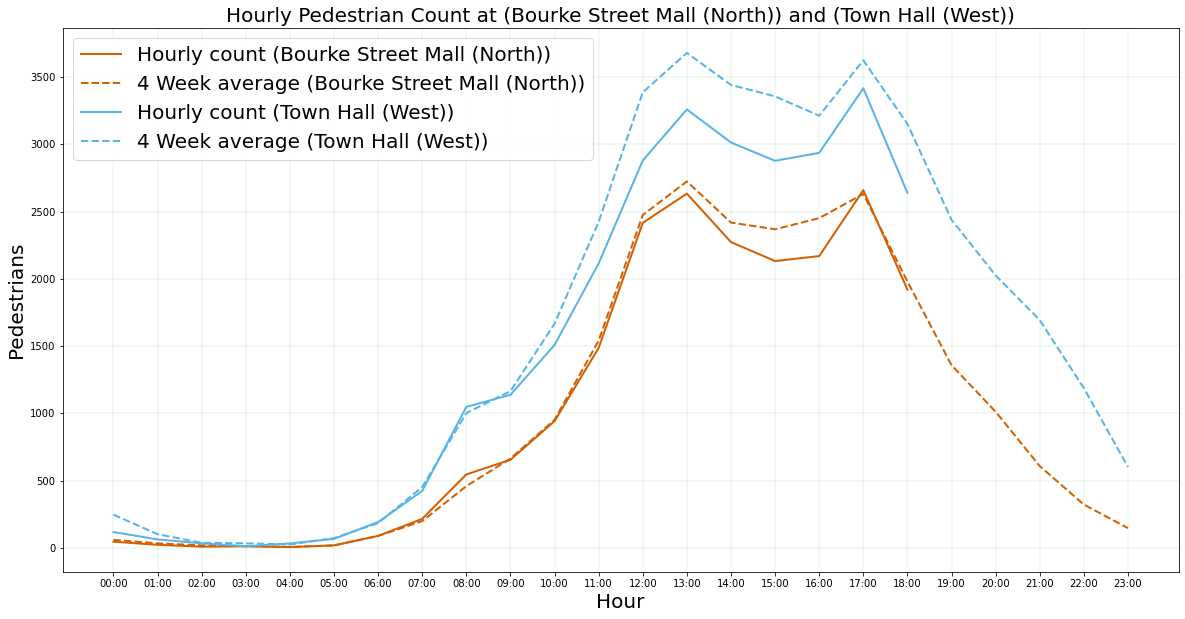

In [28]:
#Function to plot a line chart.
def line_chart(daily_data_sensor_1 , monthly_data_sensor_1, daily_data_sensor_2, monthly_data_sensor_2, sensor_1, sensor_2):
    hours = [f"0{i}:00" for i in range(0, 10)] + [f"{i}:00" for i in range(10, 24)]  
    plt.figure(figsize=(20, 10))
    plt.plot(hours, daily_data_sensor_1,  label = f'Hourly count  ({sensor_1})', linewidth=2, c = "#d55e00")
    plt.plot(hours, monthly_data_sensor_1,'--', label = f'4 Week average {sensor_1}))', linewidth=2, c="#d55e00")
    plt.plot(hours, daily_data_sensor_2, label = f'Hourly count  ({sensor_2})', linewidth=2, c = "#56b4e9")
    plt.plot(hours, monthly_data_sensor_2, "--",label = f'4 Week average {sensor_2}))', linewidth=2, c = "#56b4e9")
    labels = [f"Hourly count ({sensor_1})", f'4 Week average ({sensor_1})', f"Hourly count ({sensor_2})", f'4 Week average ({sensor_2})']
    plt.legend(labels, prop={'size': 20})
    plt.grid(color='g', linestyle='-', linewidth=0.1)
    plt.xticks(hours)
    plt.title(f"Hourly Pedestrian Count at ({sensor_1}) and ({sensor_2})", fontsize=20)
    plt.xlabel(f"Hour", fontsize=20)
    plt.ylabel(f"Pedestrians", fontsize=20)

#Function to filter dataset by Sensor ID
def trend_visualization(sensor_1, sensor_2, daily_data = daily_data, monthly_data =  monthly_data):
    sensor_1 = location_data[location_data["Sensor ID"] == sensor_1]["Sensor Description"].iloc[0]
    sensor_2 = location_data[location_data["Sensor ID"] == sensor_2]["Sensor Description"].iloc[0]
    daily_data_sensor_1 = daily_data[sensor_1]
    monthly_data_sensor_1 = monthly_data[sensor_1]
    daily_data_sensor_2 = daily_data[sensor_2]
    monthly_data_sensor_2 = monthly_data[sensor_2]
    line_chart(daily_data_sensor_1 , monthly_data_sensor_1, daily_data_sensor_2, monthly_data_sensor_2, sensor_1, sensor_2)

#Show line chart of sensor 1 and 4
trend_visualization(1,4)

Based on this visualisation, if we want to open a business that caters for the lunch time crowd then we may wish to locate our business near Bourke street mall.

However, if we want to open a business that caters to the Dinner crowd, perhaps the area in and around Melbourne Central provides better incentives. 

This goes to show just how dynamic life is in the City of Melbourne

<div class="usecase-section-header">Geographic Filter</div>

Sometimes, we require more specific information that may not be obtainable from the sensor information alone. In this example, we take specific addresses as data input instead of the Sensor location to provide a more meaningful and insightful result. 

We can create a Geographic Filter that will take a ***specific address*** such as 100 Flinders Street and create a live map and a live line chart. 

The problem is that an address may have multiple pedestrian sensors near it. Therefore, we introduce another variable called ***Radius***. This variable aims to filter all sensors that are within the radius of the target address

We then take a sum of these different sensors to access the pedestrian data of the address.

To produce this filter, we have 8 steps :

1. Take addresses
2. Use Google API to get the information about Latitude and Longitude of these addresses
3. Find the distance between these addresses and the sensors
4. Filter sensors are near these addresses
5. Create a live chart
6. Filter daily and monthly data
7. Draw a line chart

In [33]:
import googlemaps
import requests
import json
import numpy as np
import geopy.distance
from folium.plugins import MarkerCluster
from gmaps_api_key import GMAPS_API_KEY
gmaps = googlemaps.Client(key = GMAPS_API_KEY)


#This function takes an address and returns the address and it's latitude and longitude
def extract_location(filter_address_value):
    address_name = f'{filter_address_value}, Melboune, Victoria, Australia.'
    geocode_result = gmaps.geocode(address_name)
    location = geocode_result[0]["geometry"]["location"]
    return address_name, np.array([location["lat"], location["lng"]])

#This function takes the whole dataset, address, and radius_value (meter)
#and return the data of sensors that are near from the address
def geo_filter_data(dataset, filter_address_value,  radius_value):
    specific_address  = extract_location(filter_address_value)
    counting_data_filter = dataset
    counting_data_filter["distance"] =  counting_data_filter[["lat", "lon"]].apply(lambda row: distance(row, specific_address[1]), axis = 1)
    counting_data_filter = counting_data_filter[counting_data_filter["distance"] <= radius_value]
    location = [specific_address[1][0], specific_address[1][1]]
    return counting_data_filter, location

def map_visualization(data, filter_sensors, center, filter_values, radius_value):
    if filter_values == []:
        locations = []
        for i in range(len(data)):
            row =data.iloc[i]
            location = [(row.lat,row.lon)]*int(row.Count)
            locations += location
        marker_cluster  = MarkerCluster(
            locations=locations,
            overlay=True,
            control=False,
              )
        m = folium.Map(location=[-37.8167, 144.967], zoom_start=15)
        marker_cluster.add_to(m)
        folium.LayerControl().add_to(m)

        return m
    else:
        m = folium.Map(location=list(center), zoom_start=15)
        locations = []
        for location in filter_sensors:
            sensor_ids = filter_sensors[location]["sensor id"]
            center_i = filter_sensors[location]["location"]
            data_filter= data[data["Sensor ID"].isin(sensor_ids)]
            for i in range(len(data_filter)):
                row =data_filter.iloc[i]
                location_i = [(row.lat,row.lon)]*int(row.Count)
                locations += location_i
            label = folium.Popup(location, parse_html=True)
            folium.Marker(location=list(center_i), popup=label).add_to(m)
            folium.Circle(
                location=list(center_i),
                radius=radius_value,
                color='red',
                fill=True,
                fill_color='#ffffff00',
                fill_opacity=0.7,
                parse_html=True).add_to(m)
                          
        marker_cluster  = MarkerCluster(
          locations=locations,
          overlay=True,
          control=True,
        ).add_to(m)
        folium.LayerControl().add_to(m)
        return m
                
#This function caculate the distance between the address and sensors 
def distance(row, address):
    return geopy.distance.geodesic((row[0], row[1]), (address[0], address[1])).m

#This function plots the line chart
def line_chart(daily_data, monthly_data, locations, filter_address_value):
    hours = [f"0{i}:00" for i in range(0, 10)] + [f"{i}:00" for i in range(10, 24)]
    plt.figure(figsize=(20, 10))
    #If there are no geo filter value, this function will return a top 3 pedestrian sensor counts
    if filter_address_value == []:
        labels = []
        title = f"Top 3 Hourly Pedestrian Count Sensors in Melbourne, Victoria, Australia"
        colors = ["#d55e00", "#ece133", "#56b4e9"]
        for i, sensor_id in enumerate( locations):
            name = location_data[location_data["Sensor ID"] == sensor_id]["Sensor Description"].iloc[0]
            daily_data_i = list(daily_data[name])
            monthly_data_i = list(monthly_data[name])
            plt.plot(hours, daily_data_i, label = f'Hourly count at {name} today', linewidth=2, c = colors[int(i)])
            plt.plot(hours, monthly_data_i,"--", label = f'One month average at {name}',  linewidth=2, c = colors[int(i)])
            labels.append(f'Hourly count at {name} today')
            labels.append(f'One month average at {name}')
        plt.legend(labels, prop={'size': 13})
        plt.grid(color='g', linestyle='-', linewidth=0.1)
        plt.xticks(hours)
        plt.title(title, fontsize=20)
        plt.xlabel(f"Hour", fontsize=20)
        plt.ylabel(f"Pedestrians", fontsize=20)
        plt.show()
        
    #If there are geo filter values, this function will return the sums of all sensors around specific addresses
    else:
        labels = []
        title = f"Pedestrian Data Analysis at "
        colors = ["#d55e00", "#ece133", "#56b4e9", "black", "pubble"]
        #For each addrress of input addresses
        for i, location  in enumerate(locations):
            sensor_id = locations[location]["sensor id"]
            sensor_names = []
            #get all sensor's name of each address
            for sensorID in sensor_id:
                name = location_data[location_data["Sensor ID"] == sensorID]["Sensor Description"].iloc[0]
                sensor_names.append(name)
            #Filter daily and monthly data
            filter_daily_data = daily_data[sensor_names]
            filter_monthly_data = monthly_data[sensor_names]
            #Get the sum of all sensor around a address
            filter_daily_data["SUM"] =  filter_daily_data.sum(axis=1).replace(0, np.nan)
            filter_monthly_data["SUM"] =  filter_monthly_data.sum(axis=1)
            #Add daily line and monthly line for each address
            plt.plot(hours, filter_daily_data["SUM"], label = f'Hourly count at {location} today', linewidth=2, c = colors[int(i)])
            plt.plot(hours, filter_monthly_data["SUM"],"--", label = f'One month average at {location}',  linewidth=2, c = colors[int(i)])
            labels.append(f'Hourly count at {location} today')
            labels.append(f'One month average at {location}')
            plt.legend(labels, prop={'size': 13})
        plt.grid(color='g', linestyle='-', linewidth=0.1)
        plt.xticks(hours)
        plt.title(title, fontsize=20)
        plt.xlabel(f"Hour", fontsize=20)
        plt.ylabel(f"Pedestrians", fontsize=20)
        plt.show()

#This is the main part of visualization
def visualization(filter_address_values, live_counting_data = counting_data,radius_value = 200):
    if filter_address_values == []:
        center = [ -37.8167, 144.967]
        filter_sensors = None
        m = map_visualization(counting_data ,filter_sensors, center, filter_address_values, radius_value)
        top_3_sensor_IDs = list(live_counting_data.sort_values(by=['Count'], ascending=False)["Sensor ID"])[:3]
        line_chart(daily_data, monthly_data, top_3_sensor_IDs, filter_address_values)
        return m
    else:
        centers = []
        locations = {}
        for address in filter_address_values:
            data_filter,lat_long = geo_filter_data(live_counting_data,address,  radius_value)
            sensor_id = list(data_filter["Sensor ID"])
            locations[address] = {}
            locations[address]["sensor id"] = sensor_id
            locations[address]["location"] = lat_long
            centers.append(lat_long)
        center = np.mean(centers, axis=0)
        m = map_visualization(live_counting_data,locations, center, filter_address_values, radius_value)
        line_chart(daily_data, monthly_data, locations, filter_address_values)
        return m

We can visualize Pedestrian foot traffic without an address input. The function will return a live pedestrian traffic map in Melbourne and a line chart showing the three busiest pedestrian sensors.

In [ ]:
filter_address_values = []
visualization(filter_address_values , live_counting_data = counting_data,radius_value = 200)

According to the above figures, the corner at Flinders and Swanston streets, South Bank, and the intersection at Spencer st and Collins St are 3 three busiest areas in Melbourne. In addition, there are more people on the street today compared to last month's average. So to conclude, if a business wants to open their new restaurant in Melbourne, they should locate the restaurant near these areas.

More realistic, we assume that the business wants to find the most suitable place for their restaurant around the desired areas: Flinders Street Station, Southern Cross Station, and Melbourne Central Station. We now analyze pedestrian traffic at these three locations around 300 meters. We will show a line chart that will present the total pedestrian counts of all sensors within 300 meters around these addresses. We also use a live map to show pedestrian counts of all these sensors.

In [17]:
#Add three specific location into the input
filter_address_values = ["Flinder Station", "southcross station", "melbourne central station"]
visualization(filter_address_values, live_counting_data = counting_data,radius_value = 300)

NameError: name 'visualization' is not defined

From the above chart, the area around Finder Station has the highest pedestrian count now, today, and one month average. Therefore, the area around Finder Station within 300 meters is the best area to locate the restaurant. To be more specific, we use the live map to choose the best location for the restaurant. We can see that the spot at Crumpler Flinders Lane has the most pedestrian count around the Flinder Station. Therefore, Crumpler Flinders Lane is the best spot to locate the restaurant.

<div class="usecase-section-header">Congratulations!</div>

You've successfully used Melbourne Open Data to visualise pedestrian traffic in and around the City of Melbourne!<br>

In [ ]:
!jupyter nbconvert --to html Pedestrian_Traffic_Analysis_Final.ipynb

<div class="usecase-section-header">References</div>

1: https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Monthly-counts-per-hour/b2ak-trbp

2: https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Sensor-Locations/h57g-5234

3: http://python-visualization.github.io/folium/

4: https://pypi.org/project/selenium/